# Forecast of Daily Visitors of Restaurants

In [139]:
import pandas as pd
import seaborn as sb
import sklearn as sk
import numpy as np
import matplotlib.pyplot as plt

In [186]:
df_orig = pd.read_csv("./test_restaurant.csv")
df = df_orig
df

,date,num_visitors
0,2000-01-01,49.128490
1,2000-01-02,50.288060
2,2000-01-03,53.549213
3,2000-01-04,45.453240
4,2000-01-05,49.469402
...,...,...
3646,2009-12-25,31.124632
3647,2009-12-26,27.293856
3648,2009-12-27,30.218498
3649,2009-12-28,24.751186


# Step one: data processing

**Check if there is any null entry**

In [42]:
len(df.loc[data.isnull()['date'] == True].loc[df.isnull()['num_visitors'] == True])

0

**I want to find patterns in the data, and the first step was to assign an index to each sample point**

In [110]:
df = df \
    .reset_index() \
    .rename(columns={"index" : "dayNum"})
df

,dayNum,date,num_visitors
0,0,2000-01-01,49.128490
1,1,2000-01-02,50.288060
2,2,2000-01-03,53.549213
3,3,2000-01-04,45.453240
4,4,2000-01-05,49.469402
...,...,...,...
3646,3646,2009-12-25,31.124632
3647,3647,2009-12-26,27.293856
3648,3648,2009-12-27,30.218498
3649,3649,2009-12-28,24.751186


**Now let's plot the data and see if there are any visible trends**

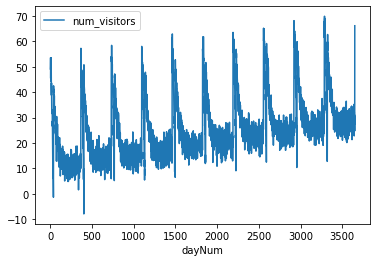

In [75]:
df.plot(x='dayNum', y='num_visitors')

**It seems like the data has a yearly cycle. It is also possible that there is a monthly and weekly cycle, so I will add these features to the data**

In [111]:
df['year'] = df['date'].apply(lambda x: int(x.split("-")[0]) - 2000)
df['month'] = df['date'].apply(lambda x: int(x.split("-")[1]) - 1)
df['day'] = df['date'].apply(lambda x: int(x.split("-")[2]) - 1)
df['weekday'] = (df['dayNum'] + 5) % 7
df

,dayNum,date,num_visitors,year,month,day,weekday
0,0,2000-01-01,49.128490,0,0,0,5
1,1,2000-01-02,50.288060,0,0,1,6
2,2,2000-01-03,53.549213,0,0,2,0
3,3,2000-01-04,45.453240,0,0,3,1
4,4,2000-01-05,49.469402,0,0,4,2
...,...,...,...,...,...,...,...
3646,3646,2009-12-25,31.124632,9,11,24,4
3647,3647,2009-12-26,27.293856,9,11,25,5
3648,3648,2009-12-27,30.218498,9,11,26,6
3649,3649,2009-12-28,24.751186,9,11,27,0


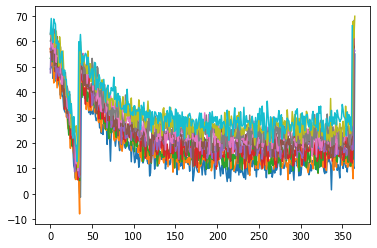

In [112]:
for year in range(10):
    df.loc[df['year'] == year].reset_index()['num_visitors'].plot()

**This is a plot of all the years overlayed on top of each other. We see a noticable spike around early February which coincides with the week of Valentines day! Also, there is a big increase around Christmas and New Year's. These will be handled by the features that I added into the data**

# Step 2: Linear Regression

I chose to use ElasticNet as it automates some hyperparameter tuning. Playing with the numbers a bit, I found that it is hard to make Linear Regression work well for this dataset. The plot shows the output of the model.

In [157]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.25)
train_X, train_Y = train[['year', 'month', 'day', 'weekday']].to_numpy(), train['num_visitors'].to_numpy()
test_X, test_Y = test[['year', 'month', 'day', 'weekday']].to_numpy(), test['num_visitors'].to_numpy()

In [179]:
from sklearn.linear_model import ElasticNet
model = ElasticNet(alpha=0.2, max_iter=1200)
model.fit(train_X, train_Y)

ElasticNet(alpha=0.2, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=1200, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [180]:
from sklearn.metrics import r2_score

print("TRAINING", r2_score(train_Y, model.predict(train_X)))
print("TESTING", r2_score(test_Y, model.predict(test_X)))

TRAINING 0.5189930256688383
TESTING 0.4639822556444291


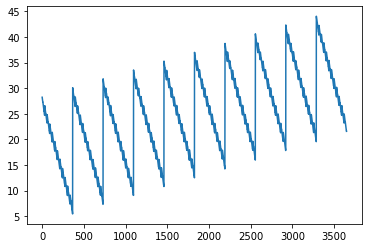

In [181]:
ys = model.predict(df[['year', 'month', 'day', 'weekday']].to_numpy())
xs = np.arange(len(ys))
sb.lineplot(xs, ys)

# Step 3: Neural Network

This took much longer to train and the data output looks okay. I believe that more features and tuning will be necessary to make this model perform better. The plot shows the output of the model.

In [182]:
from sklearn.neural_network import MLPRegressor
model = MLPRegressor(max_iter=1000)
model.fit(train_X, train_Y)

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100,), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=1000,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=None, shuffle=True, solver='adam',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)

In [183]:
from sklearn.metrics import r2_score

print("TRAINING", r2_score(train_Y, model.predict(train_X)))
print("TESTING", r2_score(test_Y, model.predict(test_X)))

TRAINING 0.840230854606653
TESTING 0.7726791842949023


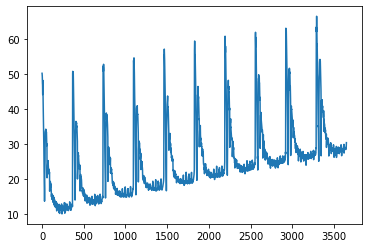

In [184]:
ys = model.predict(df[['year', 'month', 'day', 'weekday']].to_numpy())
xs = np.arange(len(ys))
sb.lineplot(xs, ys)

# Step 4: Random Forest

This took the least amount of time to train and performed the best. The plot shows the output of the model.

In [158]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor()
model.fit(train_X, train_Y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [159]:
from sklearn.metrics import r2_score

print("TRAINING", r2_score(train_Y, model.predict(train_X)))
print("TESTING", r2_score(test_Y, model.predict(test_X)))

TRAINING 0.982236798274851
TESTING 0.8392536969313007


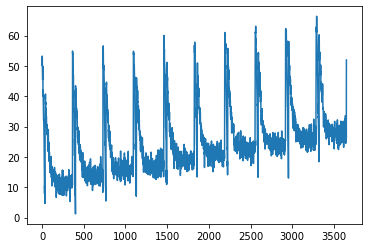

In [160]:
ys = model.predict(df[['year', 'month', 'day', 'weekday']].to_numpy())
xs = np.arange(len(ys))
sb.lineplot(xs, ys)